# Model calibrations using ML

## Structure

- given files containing smiles and parameters, extract data
- train network map f: parameters -> smile
- pick smile, train network g: theta_0 -> theta_guess (theta being parameters)


## Authors

Dr. Blanka Horvath, Aitor Muguruza Gonzalez, Mehdi Tomas

## Extract data

In [1]:
import os
os.chdir("../../Data")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time as time
import gzip
f = gzip.GzipFile('rBergomiTrainSet.txt.gz', "r")
dat=np.load(f)
print(dat.shape)
xx=dat[:,:4]
yy=dat[:,4:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(40000, 92)
(40000, 4)


In [3]:
xx[0,:]

array([ 0.0989267,  3.37706  , -0.829254 ,  0.427445 ])

# Scale and Normalize data

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    yy, xx, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale2=  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

In [27]:
def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)]

    
[x_train_transform,x_test_transform]=xtransform(X_train,X_test)

def xinversetransform(x):
    return scale2.inverse_transform(x)

In [28]:
ub=0.16,4,-0.1,0.5
lb=[0.01,0.3,-0.95,0.025]
def myscale(x):
    res=np.zeros(4)
    for i in range(4):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(4)
    for i in range(4):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res
    

In [29]:
y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])

# Create the Neural Network

In [30]:
import keras
from keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
keras.backend.set_floatx('float64')
input1 = keras.layers.Input(shape=(4,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 


x4=keras.layers.Dense(88,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,738 (37.02 KB)

 Trainable params: 4,738 (37.02 KB)

 Non-trainable params: 0 (0.00 B)

# Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [31]:
modelGEN.load_weights('RoughBergomiNNWeights.weights.h5')

In [32]:
original_weights = modelGEN.get_weights()

In [33]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

modelGEN.fit(y_train_transform, x_train_transform, batch_size=32,validation_data = (y_test_transform,x_test_transform),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - loss: 0.0103 - val_loss: 0.0093
Epoch 2/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - loss: 0.0096 - val_loss: 0.0096
Epoch 3/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - loss: 0.0096 - val_loss: 0.0087
Epoch 4/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - loss: 0.0093 - val_loss: 0.0090
Epoch 5/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - loss: 0.0092 - val_loss: 0.0090
Epoch 6/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - loss: 0.0094 - val_loss: 0.0097
Epoch 7/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - loss: 0.0093 - val_loss: 0.0109
Epoch 8/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - loss: 0.0094 - val_loss: 0.0098
Epoch 9/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - loss: 0.0093 - val_loss: 0.0098
Epoch 10/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - loss: 0.0093 - val_loss: 0.0097
Epoch 11/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - loss: 0.0095 - val_loss: 0.01

In [34]:
updated_weights = modelGEN.get_weights()

# Compare old weights with new ones

In [38]:
for i, (w_old, w_new) in enumerate(zip(original_weights, updated_weights)):
    diff = np.linalg.norm(w_new - w_old)
    print(f"Capa {i}: ||W_nuevo - W_original|| = {diff:.6f}")

Capa 0: ||W_nuevo - W_original|| = 0.485415
Capa 1: ||W_nuevo - W_original|| = 0.302918
Capa 2: ||W_nuevo - W_original|| = 3.004877
Capa 3: ||W_nuevo - W_original|| = 0.330643
Capa 4: ||W_nuevo - W_original|| = 2.300993
Capa 5: ||W_nuevo - W_original|| = 0.380376
Capa 6: ||W_nuevo - W_original|| = 1.422515
Capa 7: ||W_nuevo - W_original|| = 0.493180


## Store/Load optimal NN parameteres

In [36]:
modelGEN.save_weights('RoughBergomiNNWeights.weights.h5')

In [37]:
modelGEN.load_weights('RoughBergomiNNWeights.weights.h5')

# Numpy Implementation of the Neural Network tends to be faster than Keras

In [39]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

In [43]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(4)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad
        

interactive(children=(FloatSlider(value=0.04, description='xi0', max=0.16, min=0.01, step=0.01), FloatSlider(v…

<function __main__.plot_func(xi0, nu, rho, H)>

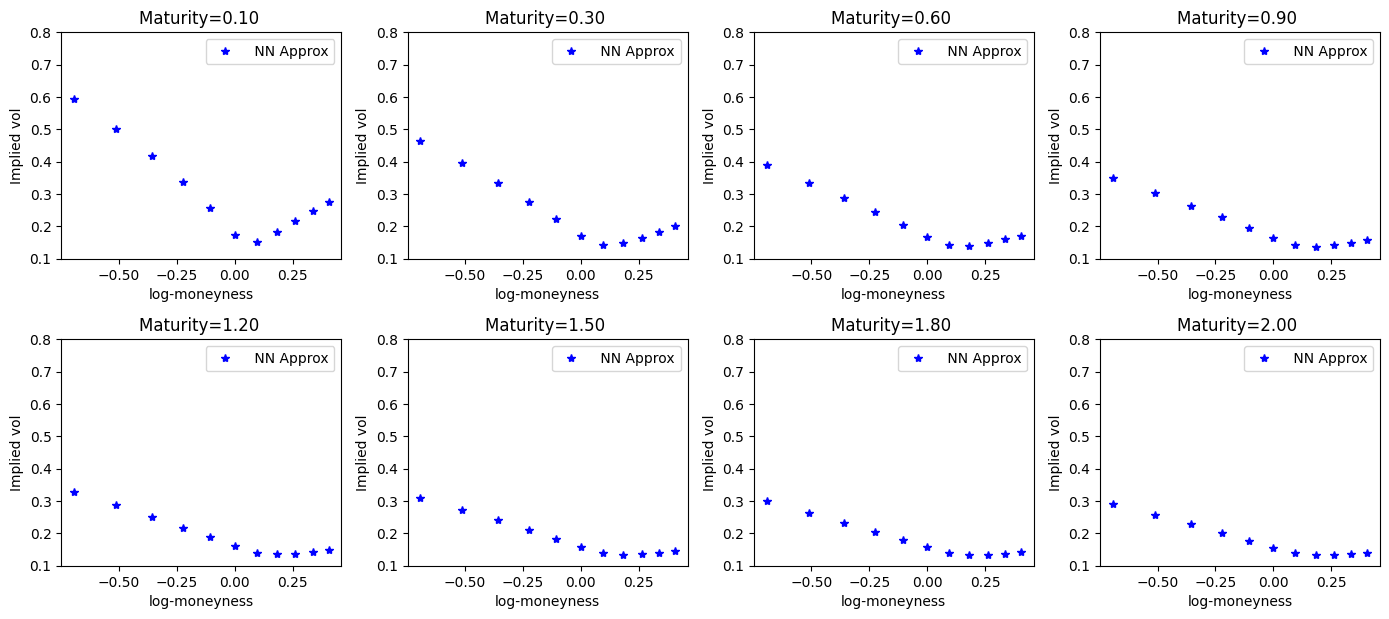

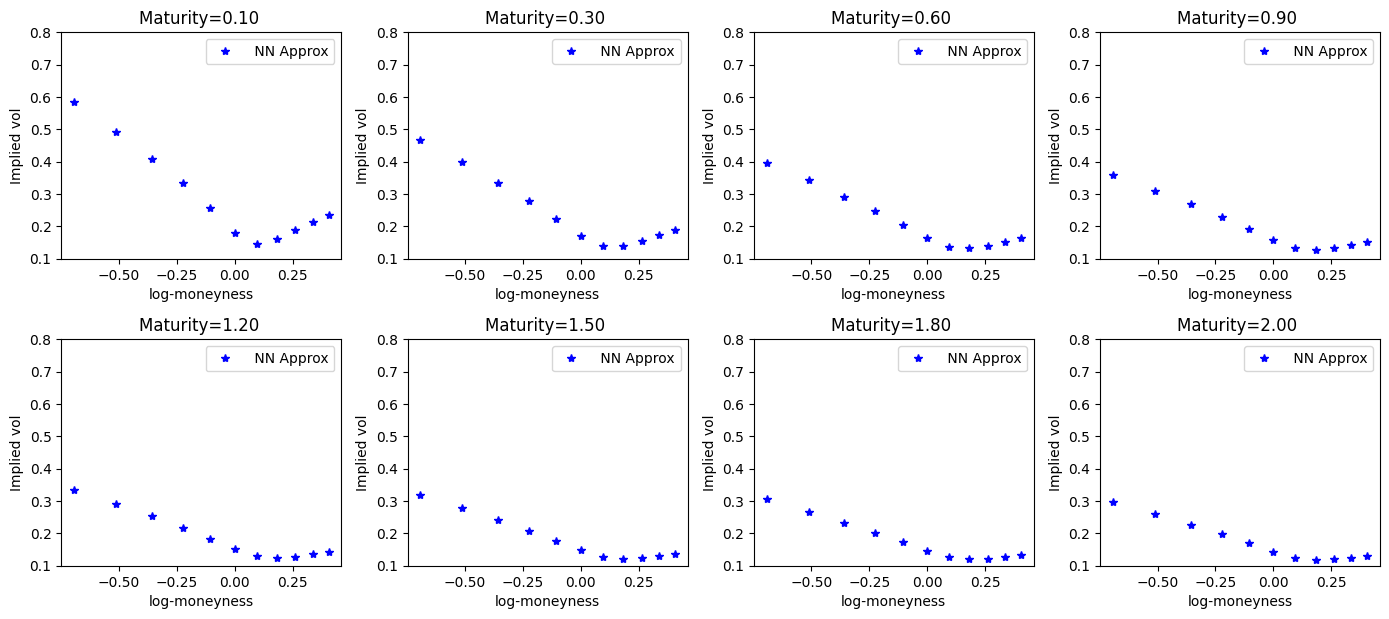

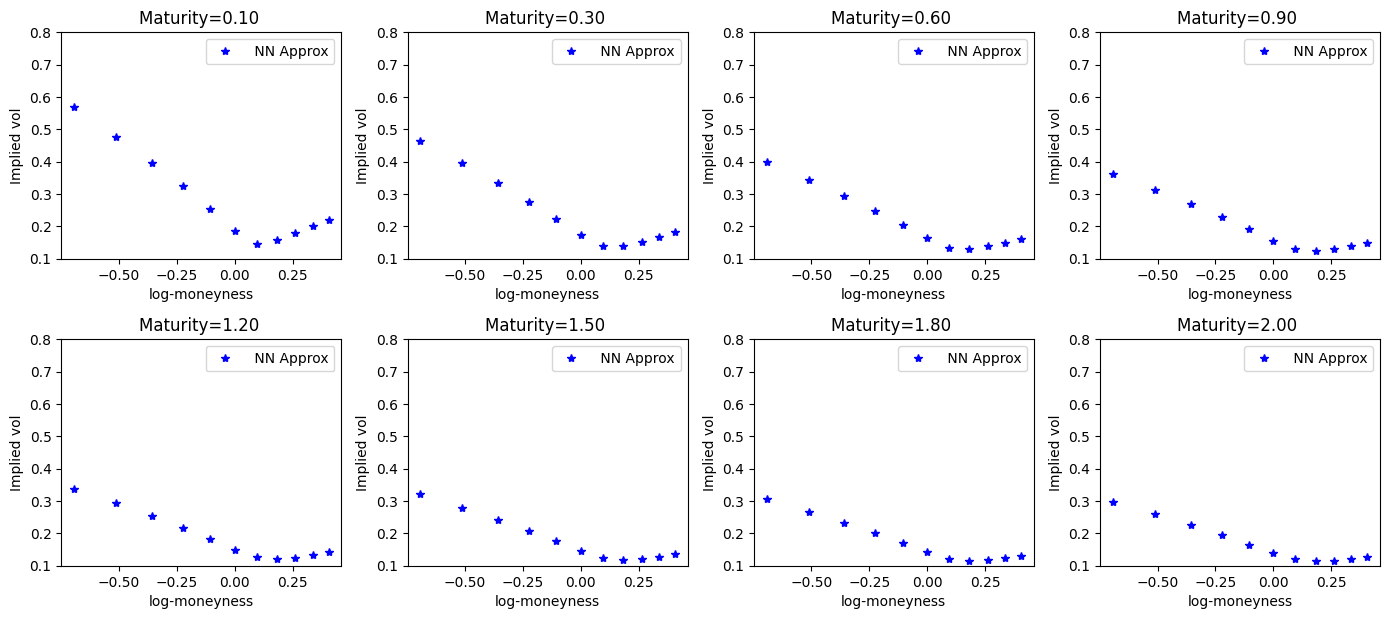

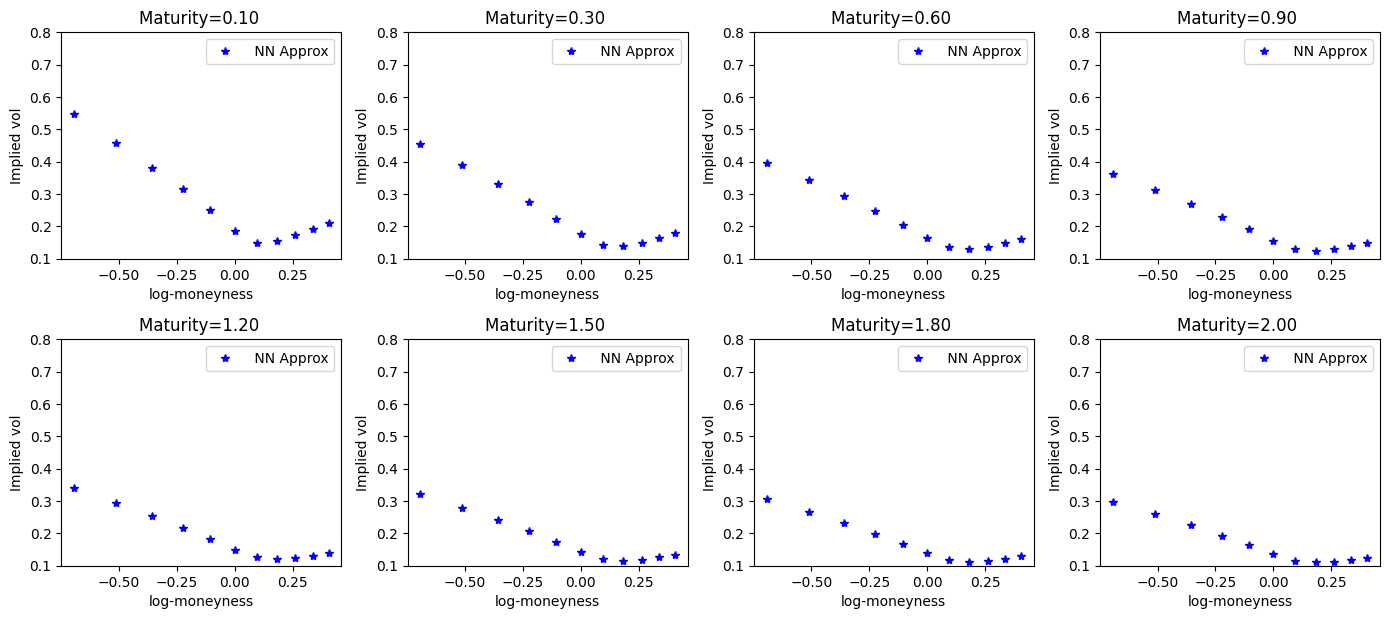

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
strikes_dim=11
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_func(xi0,nu,rho,H):
    x0=myscale(np.array([xi0,nu,rho,H]))
    Smiles=xinversetransform(NeuralNetwork(x0).reshape(1, -1)).flatten()
    plt.figure(1,figsize=(14,12))
    for i in range(8):
        plt.subplot(4,4,i+1)

        
        plt.plot(np.log(strikes/1),Smiles[i*strikes_dim:(i+1)*strikes_dim],'*b',label=" NN Approx")

        plt.ylim(0.1,0.8)
        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
ub=0.16,4,-0.1,0.5
lb=[0.01,0.3,-0.95,0.025]
interact(plot_func, xi0 = widgets.FloatSlider(value=0.04,
                                               min=0.01,
                                               max=0.16,
                                               step=0.01),
        nu = widgets.FloatSlider(value=2,
                                               min=0.3,
                                               max=4.0,
                                               step=0.1),
        rho = widgets.FloatSlider(value=-0.7,
                                               min=-0.95,
                                               max=-0.1,
                                               step=0.05),
        H = widgets.FloatSlider(value=0.1,
                                               min=0.025,
                                               max=0.5,
                                               step=0.05))

# Numpy gives 20 fold speed up

In [69]:
%timeit NeuralNetwork(y_train_transform[0])

12.5 μs ± 474 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [70]:
%timeit modelGEN.predict(y_train_transform[0].reshape(1,4))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
30.2 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%timeit NeuralNetworkGradient(y_train_transform[0])

28.6 μs ± 2.11 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Compute Implied vol relative errors on Test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

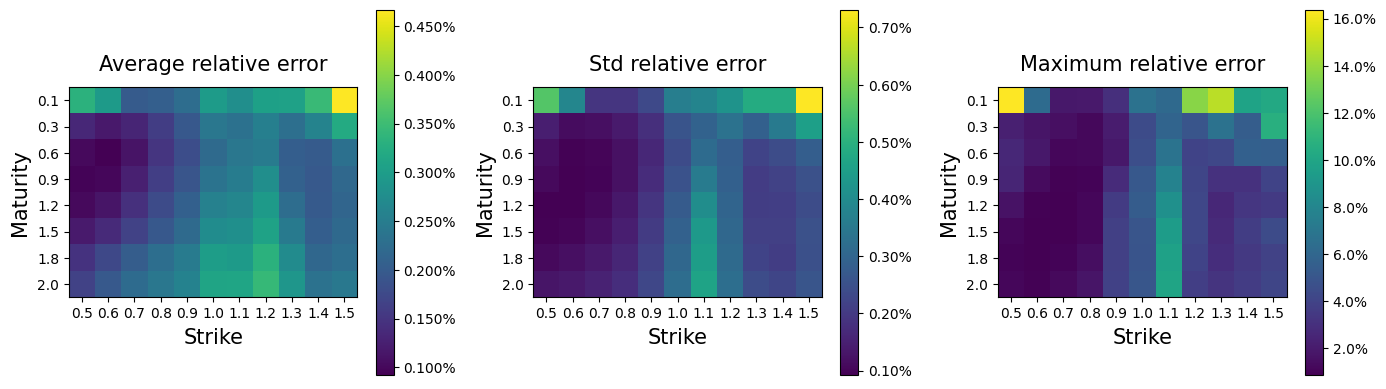

In [73]:
import numpy as np
import csv
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = xinversetransform(x_test_transform)
y_sample = y_test_transform

prediction=[xinversetransform(modelGEN.predict(y_sample[i].reshape(1,4))).flatten() for i in range(len(y_sample))]
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.savefig('rBergomiNNErrors.png', dpi=300)
plt.show()

# Plot sample Smiles

[[ 0.08628702  3.19980052 -0.48315778  0.19590783]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


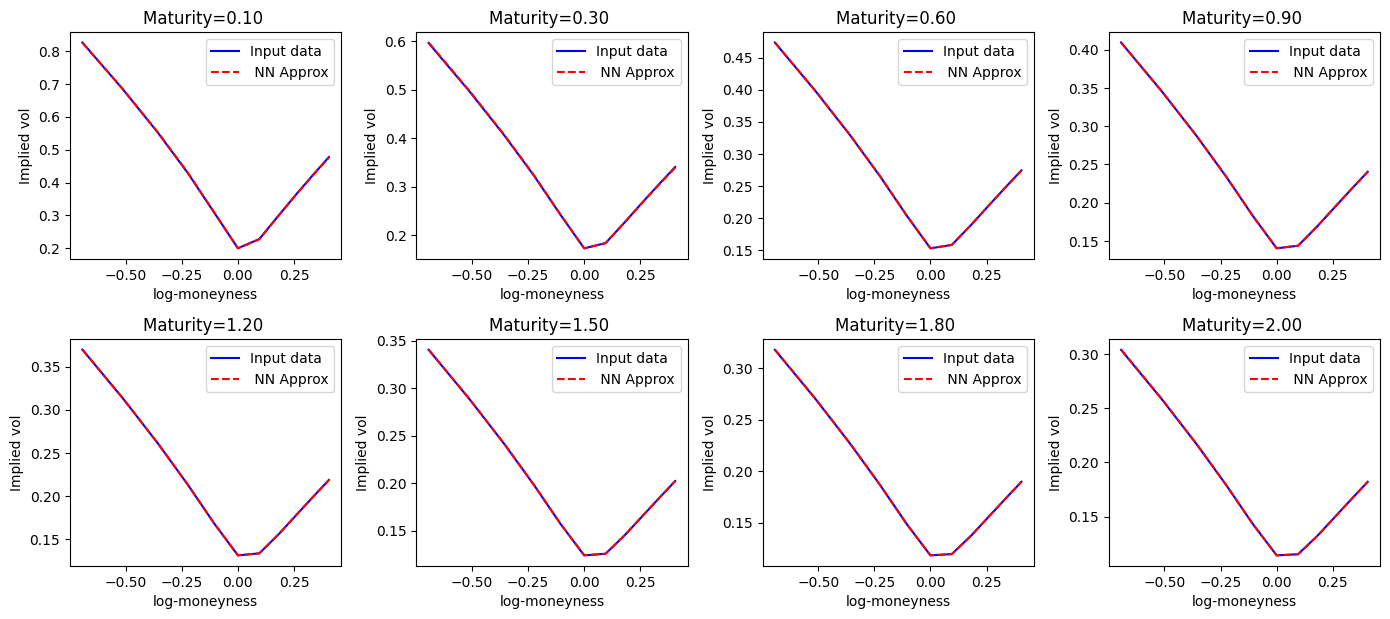

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import scipy
S0=1.

sample_ind = 125
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
print(scale.inverse_transform(y_sample.reshape(1,4)))

prediction=xinversetransform(modelGEN.predict(y_sample.reshape(1,4))).flatten()
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Use gradient methods for optimization

In [77]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-x_test_transform[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-x_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-x_test_transform[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [79]:
import scipy
Approx=[]
Timing=[]
sample_ind = 500
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
solutions=np.zeros([4,4])
times=np.zeros(4)
init=np.zeros(4)
for i in range(5000):
    disp=str(i+1)+"/5000"
    print (disp,end="\r")
    #L-BFGS-B
    start = time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    end= time.time()
    solutions[3,:]=myinverse(I.x)
    times[3]=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    

# Plot calibration times

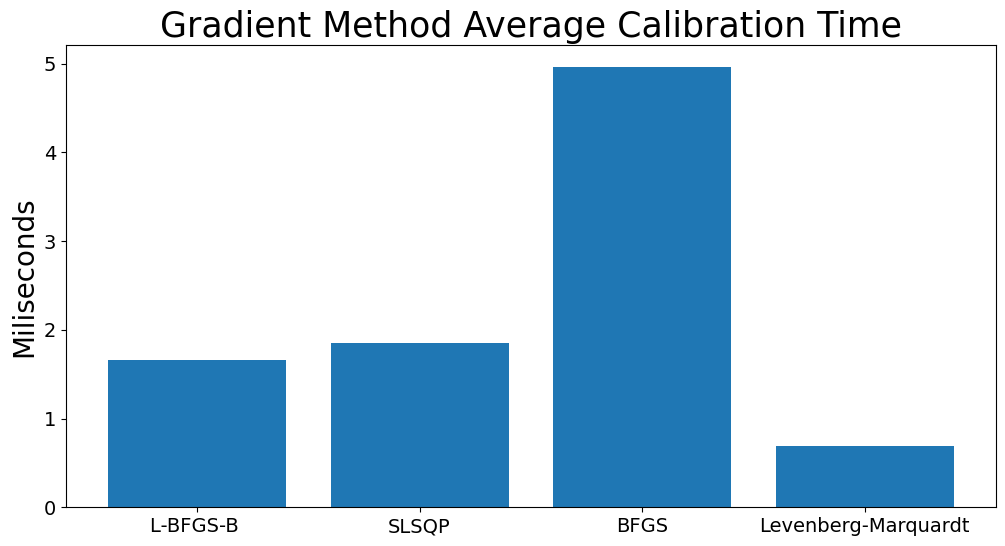

In [80]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
#plt.legend(methods)
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Save the Lavenberg-Marquardt Optimal parameters

In [81]:
LMParameters=[Approx[i][3] for i in range(len(Approx))]
np.savetxt("NNParametersRoughBergomi.txt",LMParameters)  

# Calibration Errors with Levenberg-Marquardt

average=  0.0036216204786261117
average=  0.005124510317367808
average=  0.009026517989830072
average=  0.011999479687247428


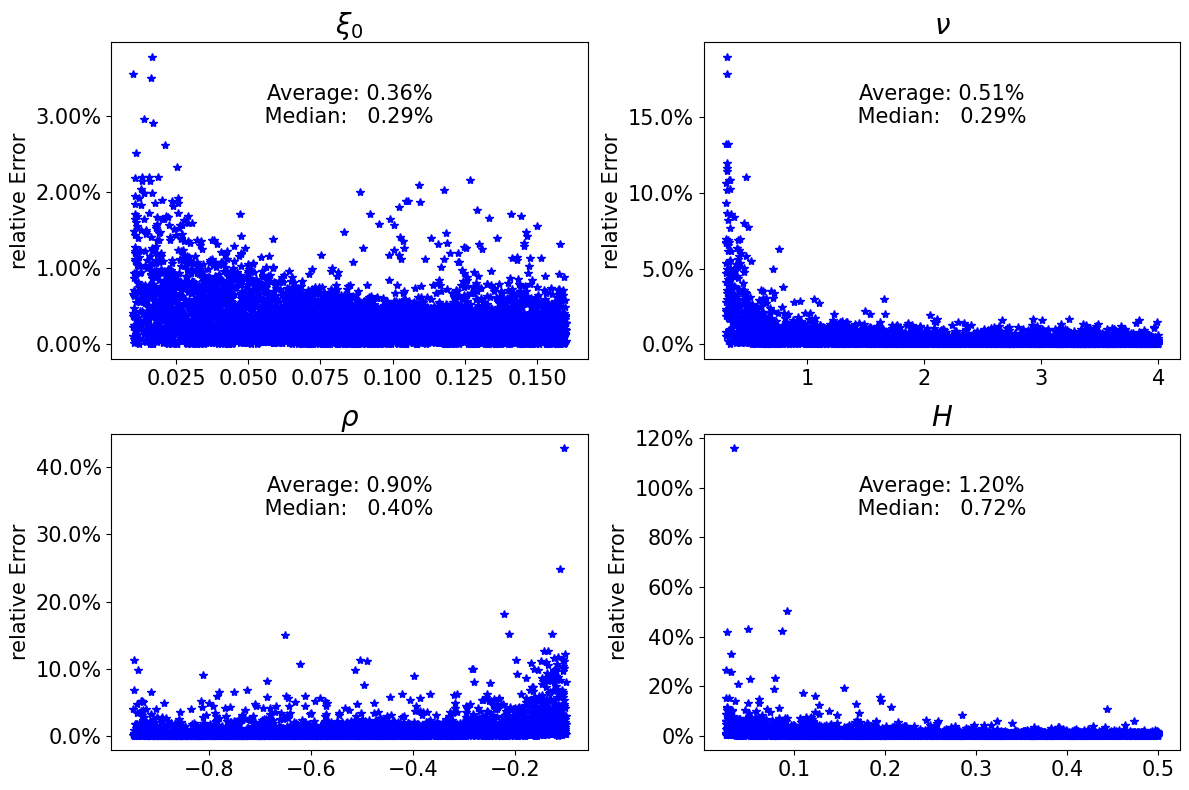

In [82]:
titles=["$\\xi_0$","$\\nu$","$\\rho$","$H$"]
average=np.zeros([4,5000])
fig=plt.figure(figsize=(12,8))
for u in range(4):
    ax=plt.subplot(2,2,u+1)
    for i in range(5000):
        
        y=y_test[i][u]
        plt.plot(y,100*np.abs(LMParameters[i][u]-y)/np.abs(y),'b*')
        average[u,i]=np.abs(LMParameters[i][u]-y)/np.abs(y)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

    print("average= ",np.mean(average[u,:]))
plt.tight_layout()
plt.savefig('rBergomiParameterRelativeErrors.png', dpi=300)
plt.show()

In [83]:
Approx=np.loadtxt("NNParametersRoughBergomi.txt")

# Load corresponding smiles generated by Monte Carlo

In [84]:
SurfacesCalib=np.loadtxt("surfacesFromNNRoughBergomi.txt")
SurfacesCalib=SurfacesCalib[:,4:]
SurfacesTarget=X_test[:5000]
#print(Surfaces2Params)

RMSENN=np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget,2),axis=1))
ind=~(RMSENN==np.inf)
RMSENN=RMSENN[ind]

/var/folders/2m/mlv2fsg14t52l377d2x2_5t40000gn/T/ipykernel_15218/3971551937.py:6: RuntimeWarning: overflow encountered in power
  RMSENN=np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget,2),axis=1))


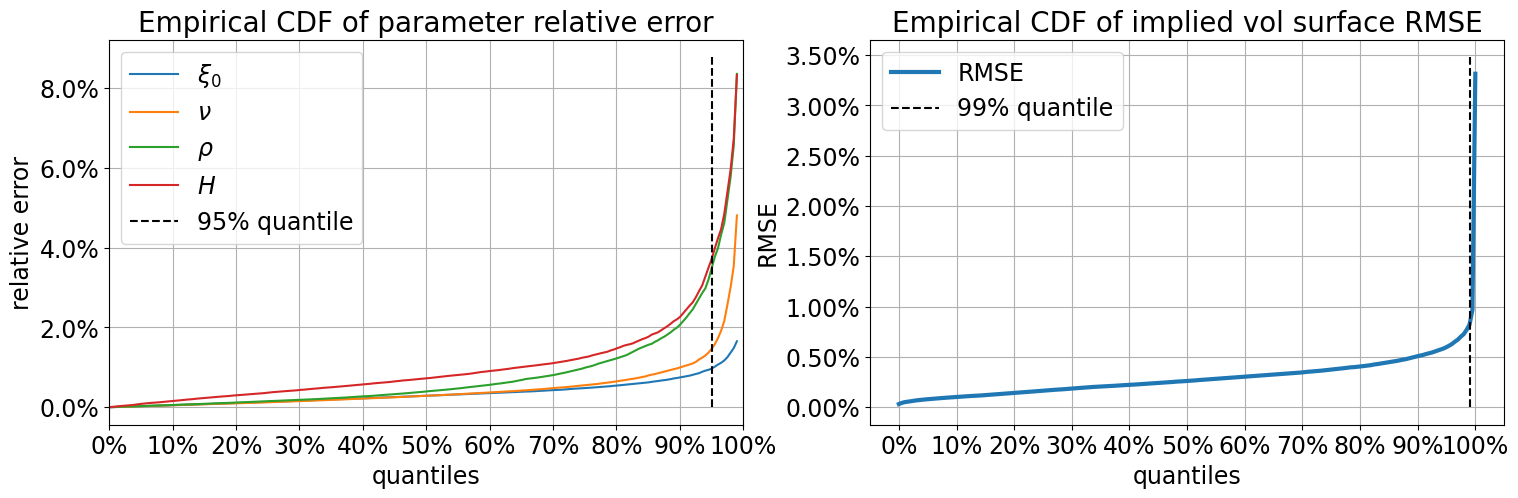

In [85]:
titles=["$\\xi_0$","$\\nu$","$\\rho$","$H$"]
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)


ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(4):
    p=plt.plot(100*q,np.quantile(100*average[u,:],q),label=titles[u])
    
    c=p[0].get_color()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(100*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter relative error",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("relative error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))

plt.grid()
plt.subplot(122)


ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(100*q,np.quantile(100*RMSENN,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(100*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('rBergomiErrorCDF.png', dpi=300)
plt.show()
